In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.model.metrics as metrics
import src.model.train as train
import src.model.ae as ae
# import src.model.gau as gaussian
import src.model.linear_probing as lp
import src.plots as plots


c:\Users\pmarc\.conda\envs\inteli_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')

In [13]:
# Extract the template and difference data
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['labels'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['labels'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['labels'], dtype=torch.float32)

# Reshape the arrays to separate timestamps
num_samples, num_photos, height, width = train_difference.shape
reshaped_train_difference = train_difference.reshape(num_samples * num_photos, height, width)
reshaped_train_template = train_template.repeat_interleave(num_photos, dim=0)
reshaped_train_class = train_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape
reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, height, width)
reshaped_val_template = validation_template.repeat_interleave(num_photos, dim=0)
reshaped_val_class = validation_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape
reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, height, width)
reshaped_test_template = test_template.repeat_interleave(num_photos, dim=0)
reshaped_test_class = test_class_0.repeat_interleave(num_photos)

# Combine the template and difference into a 2-channel image
train_dataset = torch.stack((reshaped_train_template, reshaped_train_difference), dim=2)
validation_dataset = torch.stack((reshaped_val_template, reshaped_val_difference), dim=2)
test_dataset = torch.stack((reshaped_test_template, reshaped_test_difference), dim=2)

train_dataset_0 = TensorDataset(train_dataset.permute(0, 2, 1, 3), reshaped_train_class)
validation_dataset_0 = TensorDataset(validation_dataset.permute(0, 2, 1, 3), reshaped_val_class)
test_dataset_0 = TensorDataset(test_dataset.permute(0, 2, 1, 3), reshaped_test_class)

In [8]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

model_final = ae.AE(latent_dim = 42, n_channels=2, name='final model')

max_epochs = 300
criterion = ae.loss_function
batch_size = 100 #100
lr = 0.333e-4 #propuesto en paper astorga
augmentation = True
shuffle_augmentation = False
early_stopping = 15
use_gpu = True

curves, tiempo, mse = train.train_model(model_final,
                                            train_dataset_0,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=shuffle_augmentation,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

Augmenting Data ... 
Starting training ...
Epoch 68/300 (Early Stop) -- Iteration 2513892 - Batch 36968/36969 - Train loss: 0.00086788 - Val loss: 0.00023315Tiempo total de entrenamiento: 21419.77 [s]



In [11]:
# linear probing settings
lp_epochs = 200
lp_criterion = nn.CrossEntropyLoss()
lp_batch_size = 100
lp_lr = 0.333e-4
use_gpu = False

In [12]:
train_lp, val_lp, test_lp = lp.get_latent_features([model_final], train_dataset_0, validation_dataset_0, test_dataset_0)

lp_model = lp.LinearClassifier(42, 3, 'with lr 0.333e-4')

lp_curves, lp_tiempo, lp_labels, lp_pred = lp.train_model(lp_model_3_1, train_lp[0], val_lp[0], test_lp[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

matrix = confusion_matrix(lp_labels_1_1, lp_pred_1_1)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 69559176960 bytes.

In [ ]:
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
norm = True

TypeError: 'Axes' object is not subscriptable

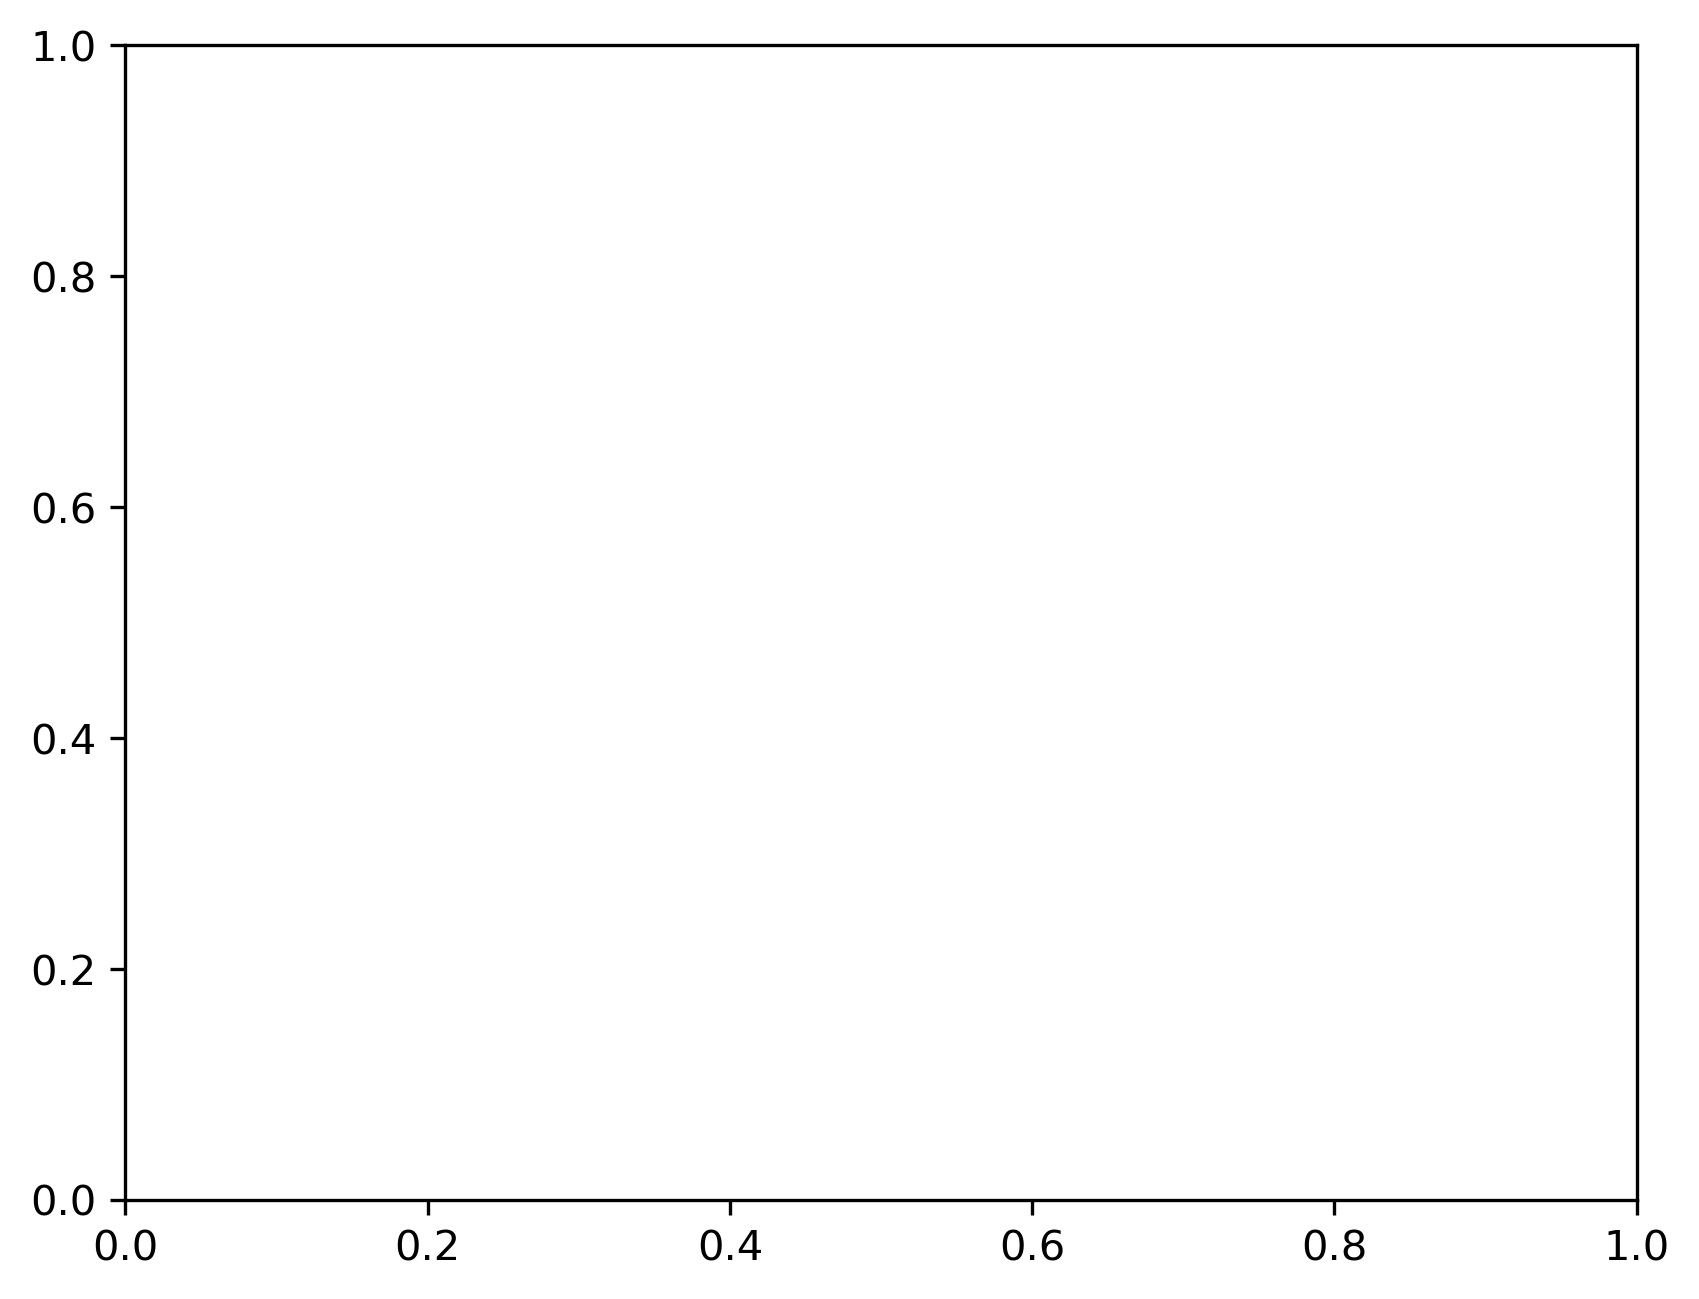

In [14]:
metrics.show_curves([curves], [model_final])
print()

In [ ]:
metrics.plot_umap([models], test_dataset_0.tensors[0], test_class_0, n_neighbors, min_dist, metric, norm)
print()

In [ ]:
metrics.plot_matrix([model_final], [matrix])
metrics.plot_umap_lp([lp_model], val_1, n_neighbors, min_dist, metric, norm)
print()